# Название проекта:телекоммуникации



Краткое Описание проекта 

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов

Цель проекта 
- Помочь бизнесу разобраться с дилемой, кому же раздать промокоды на 3 месяца яндекс плюса
- Понять, какие факторы влияют
- Достичь необходимо мнимальной auc_roc, для того, чтобы метрике можно было верить по меркам бизнеса
- Сделать рекомендации по поводу ведения дел

Задачи проекта 
- Базовый осмотр всех датасетов
- Объединение таблицы
- Анализ признаков(можно сделать его во время осмотра)
- Создание новых признаков(можно во время базового осмотра)
- Исселодвание корреляции
    - Если корреляция больше порогового значения
    - Почему в ensemble можно использовать модели с высокой корреляцией
- Исследуем и комментируем дисбаланс классов
- Выполняем отбор признаков(опционально)
- Трансформация признаков
- Исследование моделей
    - Сatboost 
    - RandomForestClassifier
- Подбор гиперпараметров 
- Выбор модели и проверка ее на тестовой выборке
- Анализ и интерпритация важности признаков 
- Анализ и интерпритация матрицы ошибок 
- Итоговый вывод рекомендации для бизнеса


Описание данных
- customerID — идентификатор абонента
- BeginDate — дата начала действия договора
- EndDate — дата окончания действия договора
- Type — тип оплаты: раз в год-два или ежемесячно
- PaperlessBilling — электронный расчётный лист
- PaymentMethod — тип платежа
- MonthlyCharges — расходы за месяц
- TotalCharges — общие расходы абонента
- customerID — идентификатор пользователя
- gender — пол
- SeniorCitizen — является ли абонент пенсионером
- Partner — есть ли у абонента супруг или супруга
- Dependents — есть ли у абонента дети
- customerID — идентификатор пользователя
- InternetService — тип подключения
- OnlineSecurity — блокировка опасных сайтов
- OnlineBackup — облачное хранилище файлов для резервного копирования данных
- DeviceProtection — антивирус
- TechSupport — выделенная линия технической поддержки
- StreamingTV — стриминговое телевидение
- StreamingMovies — каталог фильмов
- customerID — идентификатор пользователя
- MultipleLines — подключение телефона к нескольким линиям одновременно

In [1]:
pip install category_encoders

     |████████████████████████████████| 81 kB 1.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap

     |████████████████████████████████| 16.8 MB 642 kB/s eta 0:00:01    |█████████████████▋              | 9.3 MB 7.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,roc_curve
import phik
from phik import resources, report
import shap
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [5]:
try :
    internet = pd.read_csv('~/Downloads/internet_new.csv')
    personal = pd.read_csv('~/Downloads/personal_new.csv')
    contract = pd.read_csv('~/Downloads/contract_new.csv')
    phone = pd.read_csv('~/Downloads/phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

Functions

In [6]:
def features_importance_built_in(model):
    feature_importance = model.best_estimator_._final_estimator.feature_importances_
    # в этой функции я использовал код для создания графика важности признаков от catboost
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
def shap_explanation ():
    # эта функция строит график shap.summary_plot
    
    print('Title: shap values for importance')
    features_train , features_test, target_train, target_test = transform_for_shap()
    cat = CatBoostClassifier(n_estimators = 1000,learning_rate=0.06,
                             l2_leaf_reg = 4,depth = 5,border_count = 128,
                             boosting_type = 'Plain',logging_level = 'Silent'
                            )
    shap.initjs()
    cat.fit(features_train,target_train)
    explainer = shap.TreeExplainer(cat)
    shap_values = explainer(features_test)
    shap.summary_plot(shap_values, features_test)
    plt.show()
def transform_for_shap():
     # эта функция необходима для пользования shap,потому что он не поддерживает пайплайны
     # здесь я просто преобразую данные
    categorical_columns =['Type','PaymentMethod',
       'MultipleLines', 'Partner']
    numerical = ['MonthlyCharges','TotalCharges','monthQuantity','mean_month']
    scaler = StandardScaler()
    scaler.fit(features_train[numerical])
    features_train[numerical] = scaler.transform(features_train[numerical])
    features_test[numerical] = scaler.transform(features_test[numerical])
    encoder = OrdinalEncoder()
    encoder.fit(features_train[categorical_columns])
    features_train[categorical_columns] = encoder.transform(features_train[categorical_columns])
    features_test[categorical_columns] = encoder.transform(features_test[categorical_columns])
    return features_train , features_test, target_train, target_test

### Базовый осмотр данных

#### Internet

In [7]:
internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [8]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [9]:
internet.isna().sum() 

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Пропусков в internet нет 

In [10]:
internet.InternetService.count()

5517

В данной колонке значения или оптик, или dsl

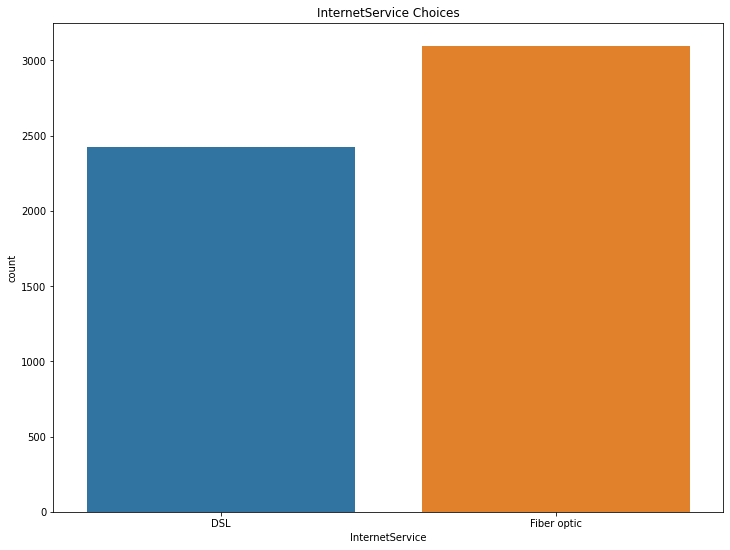

In [11]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = internet ,x = 'InternetService').set(title = 'InternetService Choices')


In [12]:
internet['OnlineBackup'].describe() 

count     5517
unique       2
top         No
freq      3088
Name: OnlineBackup, dtype: object

Также как и с InternetService- два значения

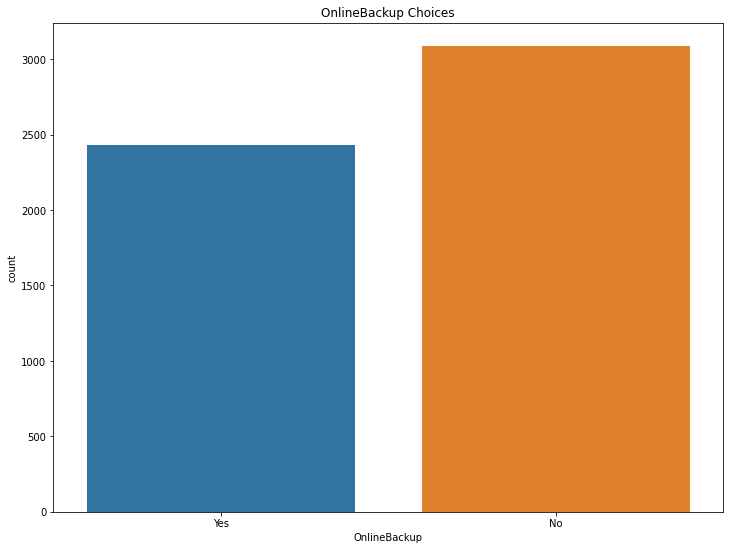

In [13]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = internet ,x = 'OnlineBackup').set(title = 'OnlineBackup Choices')


Почти одинаковые количество, данные подобраны верно

In [14]:
internet['OnlineSecurity'].describe()

count     5517
unique       2
top         No
freq      3498
Name: OnlineSecurity, dtype: object

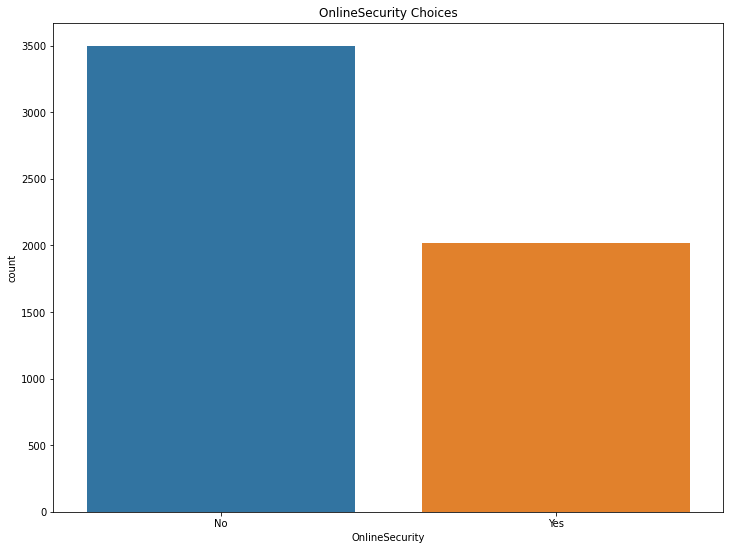

In [15]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = internet ,x = 'OnlineSecurity').set(title = 'OnlineSecurity Choices')


Здесь уже заметно, что люди чаще всего не заботятся о безопасности в интернете

In [16]:
internet['DeviceProtection'].describe()

count     5517
unique       2
top         No
freq      3095
Name: DeviceProtection, dtype: object

Можно заметить, что люди или берут или не берут защиту для их девайсов

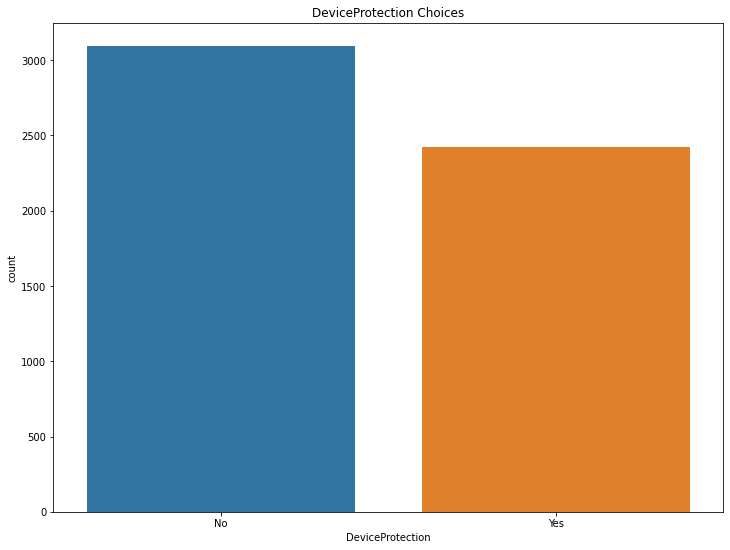

In [17]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = internet ,x = 'DeviceProtection').set(title = 'DeviceProtection Choices')


In [18]:
internet['TechSupport'].describe()

count     5517
unique       2
top         No
freq      3473
Name: TechSupport, dtype: object

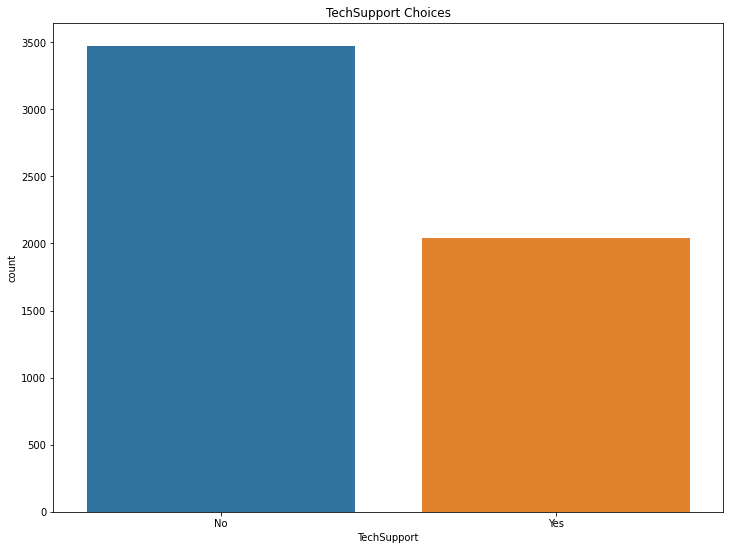

In [19]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = internet ,x = 'TechSupport').set(title = 'TechSupport Choices')


Люди в основном не пользуются технической поддержкой

In [20]:
internet['StreamingTV'].describe()

count     5517
unique       2
top         No
freq      2810
Name: StreamingTV, dtype: object

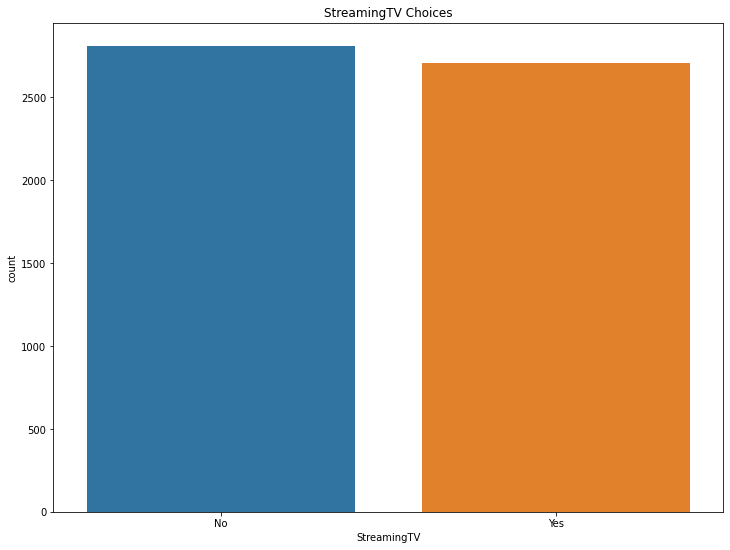

In [21]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = internet ,x = 'StreamingTV').set(title = 'StreamingTV Choices')


Люди разделились поровну в выборе 

In [22]:
internet['OnlineBackup'].describe()

count     5517
unique       2
top         No
freq      3088
Name: OnlineBackup, dtype: object

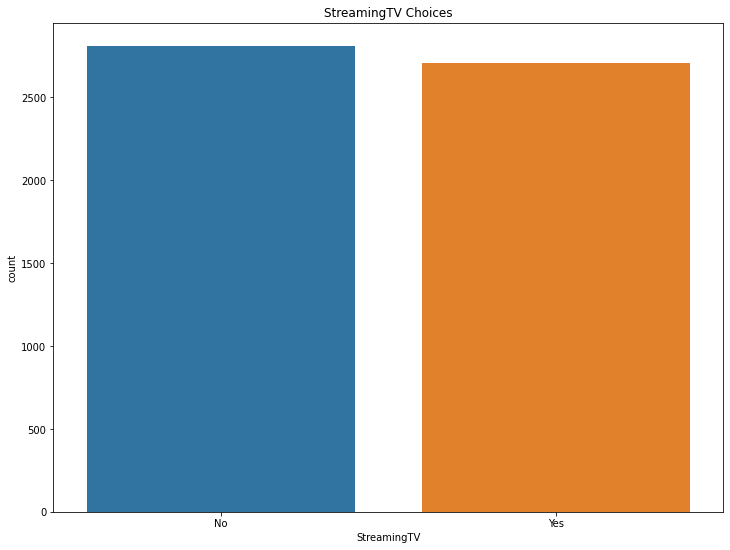

In [23]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = internet ,x = 'StreamingTV').set(title = 'StreamingTV Choices')


In [24]:
internet.head() 


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

Как мы видим, многие признаки это простые да или нет, их мы заменим далее в обработке

#### Contract




In [25]:
contract.head()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5

In [26]:
contract.isna().sum() 

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Пропуски отсуствуют, очень хорошо!

In [27]:
contract.Type.describe()

count               7043
unique                 3
top       Month-to-month
freq                3875
Name: Type, dtype: object

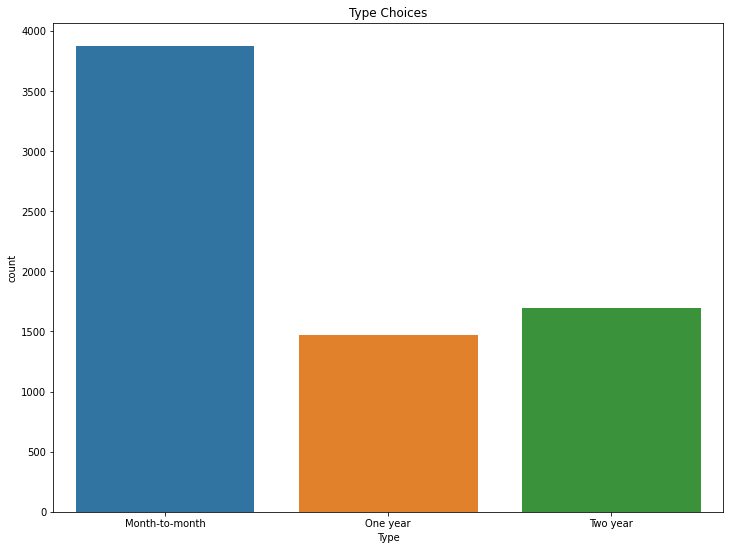

In [28]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = contract ,x = 'Type').set(title = 'Type Choices')


Можно отметить, что люди во основном выбирают вариант ежемесячной оплаты

In [29]:
contract.PaperlessBilling.unique()

array(['Yes', 'No'], dtype=object)

Логично, что люди не могут иметь третьего варианты по оплате

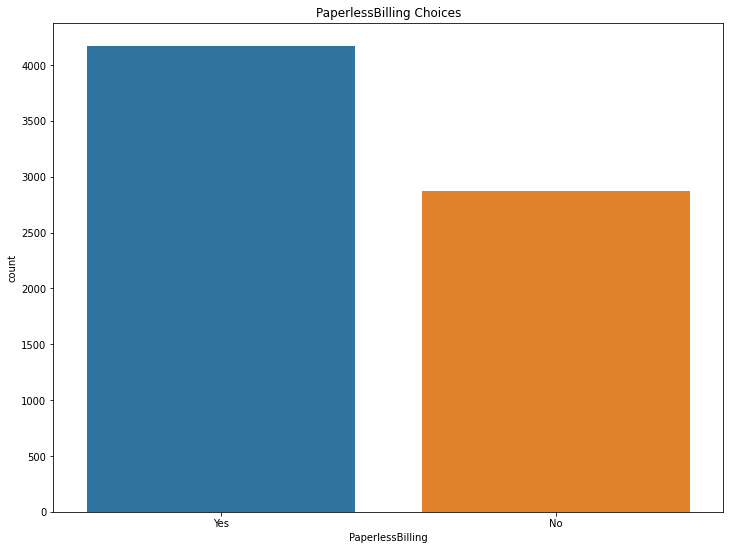

In [30]:
f, ax = plt.subplots(figsize=(12, 9))

a = sb.countplot(data = contract ,x = 'PaperlessBilling').set(title = 'PaperlessBilling Choices')


Большинство людей оплачивают счета онлайн

In [31]:
contract.PaymentMethod.unique() 

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Несколько видов оплаты, предпологаю, что они будут сильно коррелировать с PaperlessBilling.

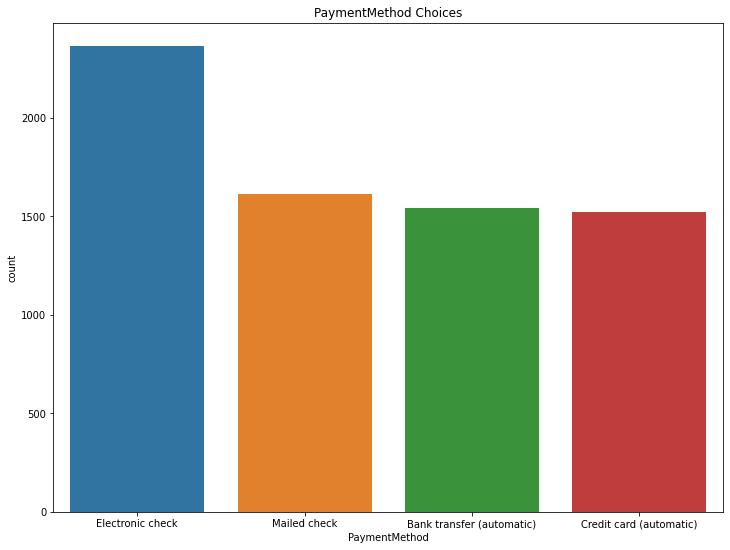

In [32]:
f, ax = plt.subplots(figsize=(12, 9))
g = sb.countplot(data = contract ,x = 'PaymentMethod').set(title = 'PaymentMethod Choices')


В основном люди пользуются электронными чеками, заметен большой gap между другими способами оплаты

In [33]:
contract.MonthlyCharges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

Можно заметить, что есть опредленная ежемесячная плата на самом базовом плане, это можно вынести как особенность

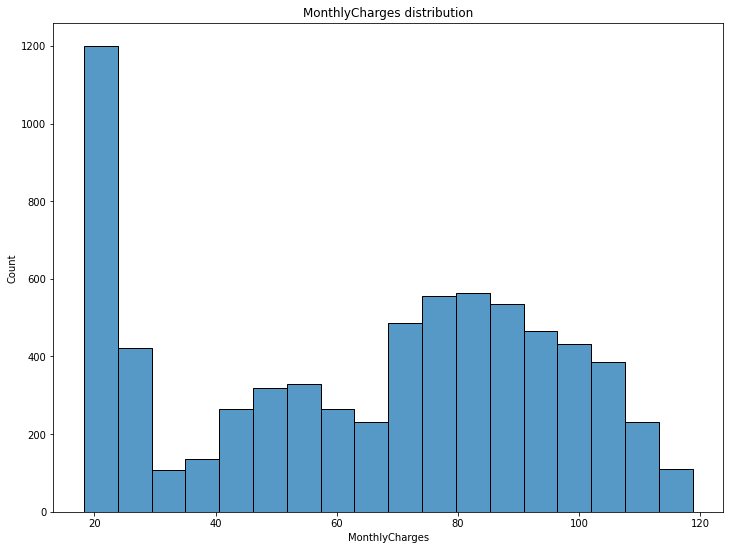

In [34]:
f, ax = plt.subplots(figsize=(12, 9))
g = sb.histplot(data = contract ,x = 'MonthlyCharges').set(title = 'MonthlyCharges distribution')


Эта месячная плата в районе 20

In [35]:
contract[contract.TotalCharges == ' '].count() # всего 11 значений, значит, можно удалить

customerID          11
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
dtype: int64

Всего 11 значений, нужно найти способ замены

In [36]:
contract[contract.BeginDate == '2020-02-01']

customerID   BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01      No  Two year              Yes   
753   3115-CZMZD  2020-02-01      No  Two year               No   
936   5709-LVOEQ  2020-02-01      No  Two year               No   
1082  4367-NUYAO  2020-02-01      No  Two year               No   
1340  1371-DWPAZ  2020-02-01      No  Two year               No   
3331  7644-OMVMY  2020-02-01      No  Two year               No   
3826  3213-VVOLG  2020-02-01      No  Two year               No   
4380  2520-SGTTA  2020-02-01      No  Two year               No   
5218  2923-ARZLG  2020-02-01      No  One year              Yes   
6670  4075-WKNIU  2020-02-01      No  Two year               No   
6754  2775-SEFEE  2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  
488   Bank transfer (automatic)           52.55               
753                Mailed check           20.25               
936                Mailed check           80.85               
1082               Mailed check           25.75               
1340    Credit card (automatic)           56.05               
3331               Mailed check           19.85               
3826               Mailed check           25.35               
4380               Mailed check           20.00               
5218               Mailed check           19.70               
6670               Mailed check           73.35               
6754  Bank transfer (automatic)           61.90

Стало понятно, что это послдений месяц, он не закончился, поэтому тотал = траты в месяце. Теперь, заменим их

In [37]:
contract.loc[contract.BeginDate == '2020-02-01','TotalCharges'] = contract[contract.BeginDate == '2020-02-01']['MonthlyCharges']

Я заменил отсутствующие значения на значения в последнем месяце, а остальные на тип данных - флоат, чтобы с ними можно было работать

In [38]:
contract.TotalCharges = contract.TotalCharges.apply(lambda x: float(x))

In [39]:
contract.head()

customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  
0           Electronic check           29.85         31.04  
1               Mailed check           56.95       2071.84  
2               Mailed check           53.85        226.17  
3  Bank transfer (automatic)           42.30       1960.60  
4           Electronic check           70.70        353.50

In [40]:
contract.TotalCharges.describe() 

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

Среднее и медиана не совпадают

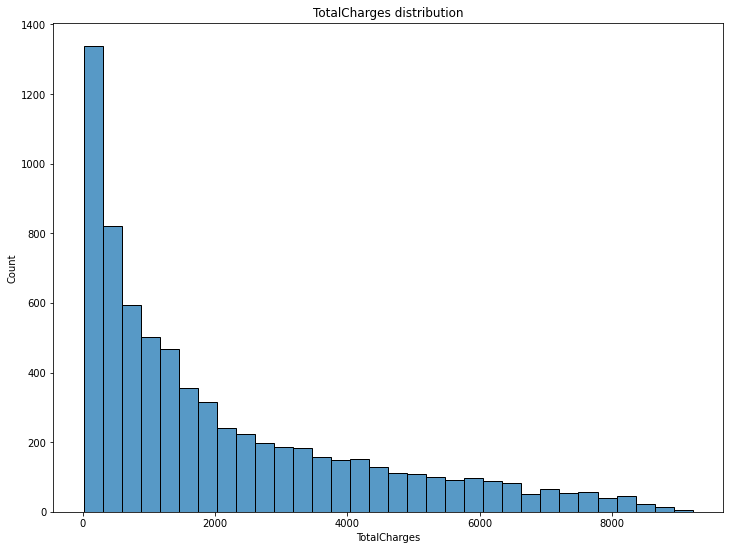

In [41]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.histplot(data = contract ,x = 'TotalCharges').set(title = 'TotalCharges distribution')

Очевидно, что никакими распределениями тут и не пахнет, потому что это накопительная переменная, все начинают с разных дат

##### Begindate

In [42]:
contract.BeginDate.describe() 

count           7043
unique            77
top       2014-02-01
freq             366
Name: BeginDate, dtype: object

Тип даты надо поменять на рабочий: datetime64, иначе тяжело будет работать с ними 

In [43]:
contract.BeginDate = contract.BeginDate.astype('datetime64')

In [44]:
contract.BeginDate.head()

0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: BeginDate, dtype: datetime64[ns]

In [45]:
fig = px.line(contract.groupby(by = 'BeginDate').agg({'MonthlyCharges' : 'sum'}))
fig.show() 

Mожно заметить, что сервис стартовал в 2014, что заметно по огромного притоку клиентов, а в середине 2019, клиенты начали уходить

In [46]:
len(contract.customerID.unique()),len(contract) 

(7043, 7043)

нет повторений в контракте

In [47]:
contract.head() 

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01      No        One year               No   
4  9237-HQITU 2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  
0           Electronic check           29.85         31.04  
1               Mailed check           56.95       2071.84  
2               Mailed check           53.85        226.17  
3  Bank transfer (automatic)           42.30       1960.60  
4           Electronic check           70.70        353.50

в данном случае end-date и является таргетом

##### End_date

In [48]:
contract['EndDateNotTarget']= contract.EndDate.apply(lambda x : '2020-02-01' if x == 'No' else x)

In [49]:
contract.EndDateNotTarget

0       2020-02-01
1       2020-02-01
2       2020-02-01
3       2020-02-01
4       2020-02-01
           ...    
7038    2020-02-01
7039    2020-02-01
7040    2020-02-01
7041    2020-02-01
7042    2020-02-01
Name: EndDateNotTarget, Length: 7043, dtype: object

In [50]:
contract['EndDateNotTarget'] = contract['EndDateNotTarget'].astype('datetime64')

In [51]:
contract

customerID  BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01      No        One year               No   
2     3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01      No        One year               No   
4     9237-HQITU 2019-09-01      No  Month-to-month              Yes   
...          ...        ...     ...             ...              ...   
7038  6840-RESVB 2018-02-01      No        One year              Yes   
7039  2234-XADUH 2014-02-01      No        One year              Yes   
7040  4801-JZAZL 2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges EndDateNotTarget  
0              Electronic check           29.85         31.04       2020-02-01  
1                  Mailed check           56.95       2071.84       2020-02-01  
2                  Mailed check           53.85        226.17       2020-02-01  
3     Bank transfer (automatic)           42.30       1960.60       2020-02-01  
4              Electronic check           70.70        353.50       2020-02-01  
...                         ...             ...           ...              ...  
7038               Mailed check           84.80       2035.20       2020-02-01  
7039    Credit card (automatic)          103.20       7430.40       2020-02-01  
7040           Electronic check           29.60        325.60       2020-02-01  
7041               Mailed check           74.40        520.80       2020-02-01  
7042  Bank transfer (automatic)          105.65       7251.82       2020-02-01  

[7043 rows x 9 columns]

Для удобства работы с новыми переменными создал другую переменную

In [52]:
contract[contract.EndDate != 'No']['EndDate'].count() # целых 1101 юзеров закончили сотрудничество с компанией

1101

#### Personal

In [53]:
personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

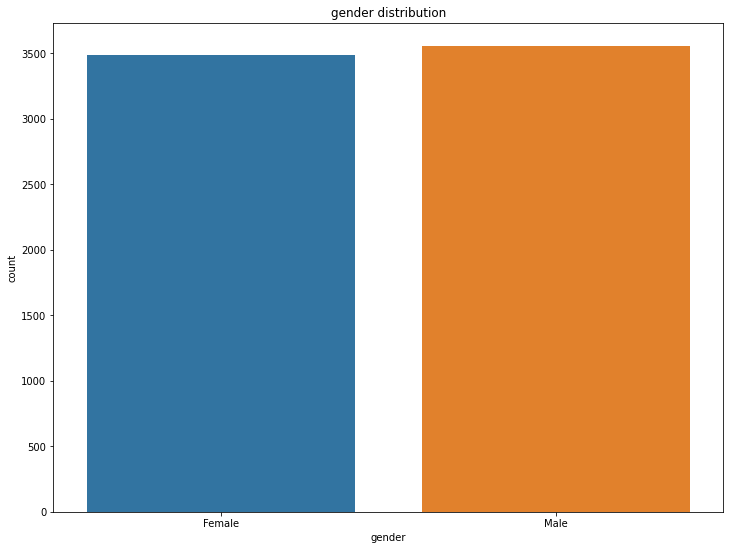

In [54]:
f, ax = plt.subplots(figsize=(12, 9)) 
a = sb.countplot(data = personal ,x = 'gender').set(title = 'gender distribution')


Мужчин и женщин поровну

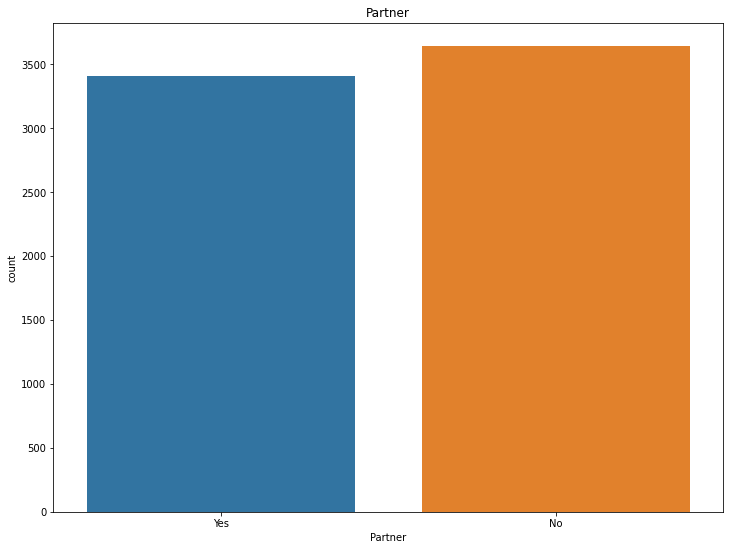

In [55]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = personal ,x = 'Partner').set(title = 'Partner')


Tоже почти идеально разделено пополам

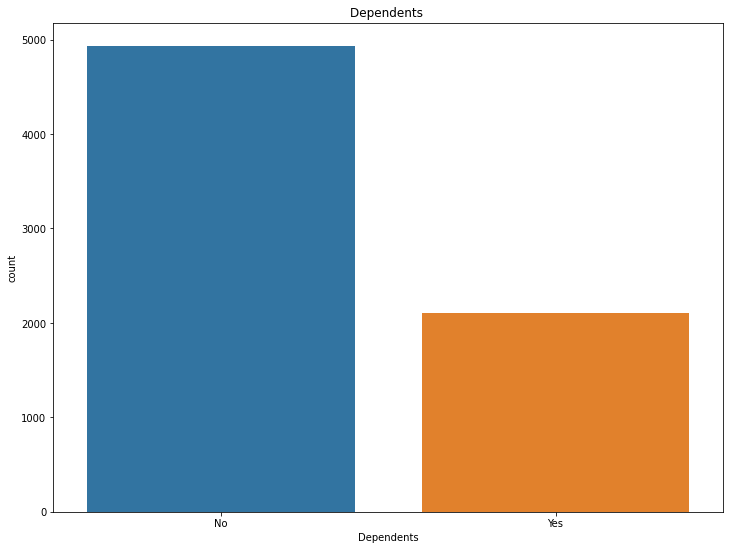

In [56]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = personal ,x = 'Dependents').set(title = 'Dependents ')


У большинства нет детей, что может дать хороший прирост

In [57]:
personal.SeniorCitizen.describe()

count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: SeniorCitizen, dtype: float64

SeniorCitizen выполнен в стиле дамми, что упрощает работу с данным столбцом, на графике 1 - SeniorCitizen,0 - не SeniorCitizen

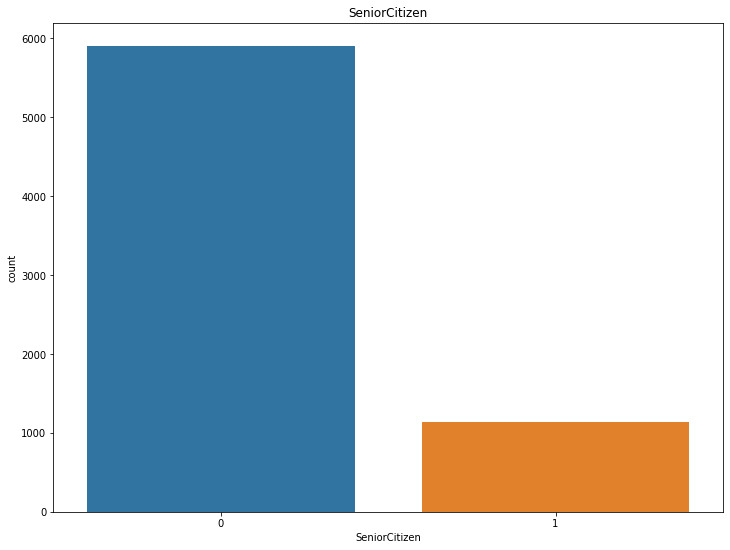

In [58]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = personal ,x = 'SeniorCitizen').set(title = 'SeniorCitizen')

#### Phone

In [59]:
phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [60]:
phone.MultipleLines.describe()

count     6361
unique       2
top         No
freq      3390
Name: MultipleLines, dtype: object

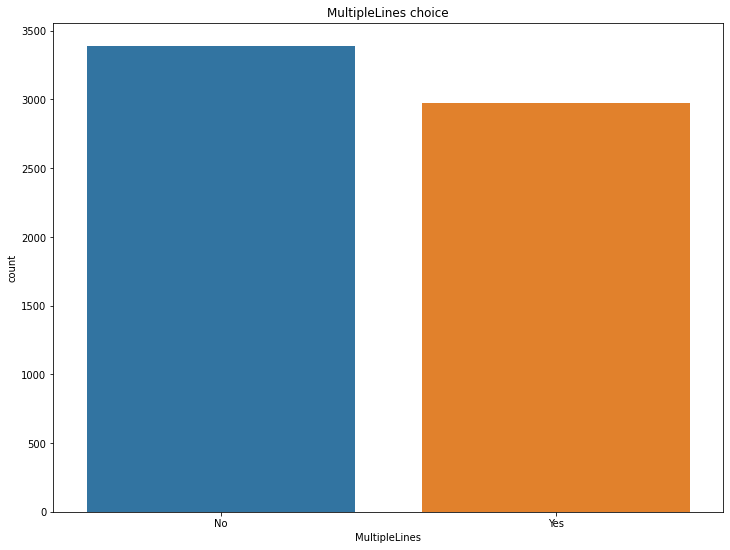

In [61]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = phone ,x = 'MultipleLines').set(title = 'MultipleLines choice')


Наличие распределно нормально

### Объединение таблицы

In [62]:
data = contract.merge(internet, how = 'left')

In [63]:
data.head()

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01      No        One year               No   
4  9237-HQITU 2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges EndDateNotTarget  \
0           Electronic check           29.85         31.04       2020-02-01   
1               Mailed check           56.95       2071.84       2020-02-01   
2               Mailed check           53.85        226.17       2020-02-01   
3  Bank transfer (automatic)           42.30       1960.60       2020-02-01   
4           Electronic check           70.70        353.50       2020-02-01   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies  
0          No              No  
1          No              No  
2          No              No  
3          No              No  
4          No              No

In [64]:
data = data.merge(phone, how = 'left')

In [65]:
data.head()

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01      No        One year               No   
4  9237-HQITU 2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges EndDateNotTarget  \
0           Electronic check           29.85         31.04       2020-02-01   
1               Mailed check           56.95       2071.84       2020-02-01   
2               Mailed check           53.85        226.17       2020-02-01   
3  Bank transfer (automatic)           42.30       1960.60       2020-02-01   
4           Electronic check           70.70        353.50       2020-02-01   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies MultipleLines  
0          No              No           NaN  
1          No              No            No  
2          No              No            No  
3          No              No           NaN  
4          No              No            No

In [66]:
data = data.merge(personal, how = 'left')

In [67]:
data

customerID  BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01      No        One year               No   
2     3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01      No        One year               No   
4     9237-HQITU 2019-09-01      No  Month-to-month              Yes   
...          ...        ...     ...             ...              ...   
7038  6840-RESVB 2018-02-01      No        One year              Yes   
7039  2234-XADUH 2014-02-01      No        One year              Yes   
7040  4801-JZAZL 2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  \
0              Electronic check           29.85         31.04   
1                  Mailed check           56.95       2071.84   
2                  Mailed check           53.85        226.17   
3     Bank transfer (automatic)           42.30       1960.60   
4              Electronic check           70.70        353.50   
...                         ...             ...           ...   
7038               Mailed check           84.80       2035.20   
7039    Credit card (automatic)          103.20       7430.40   
7040           Electronic check           29.60        325.60   
7041               Mailed check           74.40        520.80   
7042  Bank transfer (automatic)          105.65       7251.82   

     EndDateNotTarget InternetService  ... OnlineBackup DeviceProtection  \
0          2020-02-01             DSL  ...          Yes               No   
1          2020-02-01             DSL  ...           No              Yes   
2          2020-02-01             DSL  ...          Yes               No   
3          2020-02-01             DSL  ...           No              Yes   
4          2020-02-01     Fiber optic  ...           No               No   
...               ...             ...  ...          ...              ...   
7038       2020-02-01             DSL  ...           No              Yes   
7039       2020-02-01     Fiber optic  ...          Yes              Yes   
7040       2020-02-01             DSL  ...           No               No   
7041       2020-02-01     Fiber optic  ...           No               No   
7042       2020-02-01     Fiber optic  ...           No              Yes   

     TechSupport StreamingTV StreamingMovies MultipleLines  gender  \
0             No          No              No           NaN  Female   
1             No          No              No            No    Male   
2             No          No              No            No    Male   
3            Yes          No              No           NaN    Male   
4             No          No              No            No  Female   
...          ...         ...             ...           ...     ...   
7038         Yes         Yes             Yes           Yes    Male   
7039          No         Yes             Yes           Yes  Female   
7040          No          No              No           NaN  Female   
7041          No          No              No           Yes    Male   
7042         Yes         Yes             Yes            No    Male   

     SeniorCitizen  Partner Dependents  
0                0      Yes         No  
1                0       No         No  
2                0       No         No  
3                0       No         No  
4                0       No         No  
...            ...      ...        ...  
7038             0      Yes        Yes  
7039             0      Yes        Yes  
7040             0      Yes        Yes  
7041             1      Yes         No  
7042             0       No         No  

[7043 rows x 21 columns]

In [68]:
data.loc[data['MultipleLines'] == 'no_phone']

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, EndDateNotTarget, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, gender, SeniorCitizen, Partner, Dependents]
Index: []

[0 rows x 21 columns]

In [69]:
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'EndDateNotTarget',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'gender', 'SeniorCitizen', 'Partner', 'Dependents'],
      dtype='object')

#### Target

In [70]:
data['target'] = data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

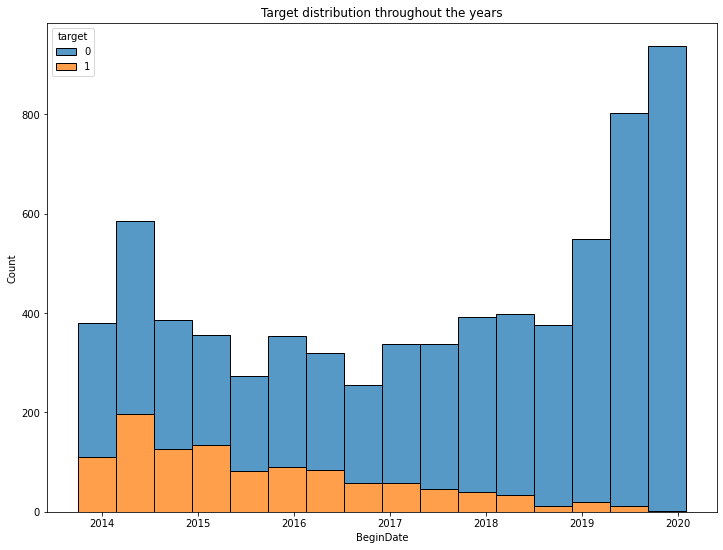

In [71]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.histplot(data,x = 'BeginDate',hue = 'target',
                multiple='stack').set(title = 'Target distribution throughout the years')

Результаты анализа:
- Спайк ухода людей в районе 2014 и до 2015
- После многочисленного ухода, стало меньше уходить людей
- В итоге количество ушедших ежегодно свелось к минимуму к 2020

### Рассмотрение таблицы после объдинения

#### Пропуски

In [72]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
EndDateNotTarget       0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
target                 0
dtype: int64

Так как мы сделали leftjoin у нас много пропусков, нужно их рассмотреть

In [73]:
data[data.InternetService.isna()]

customerID  BeginDate EndDate            Type PaperlessBilling  \
11    7469-LKBCI 2018-10-01      No        Two year               No   
16    8191-XWSZG 2015-10-01      No        One year               No   
21    1680-VDCWW 2019-02-01      No        One year               No   
22    1066-JKSGK 2019-11-01      No  Month-to-month               No   
33    7310-EGVHZ 2020-01-01      No  Month-to-month               No   
...          ...        ...     ...             ...              ...   
7017  4807-IZYOZ 2015-11-01      No        Two year               No   
7019  9710-NJERN 2016-11-01      No        Two year               No   
7020  9837-FWLCH 2019-02-01      No  Month-to-month              Yes   
7030  0871-OPBXW 2019-12-01      No  Month-to-month              Yes   
7037  2569-WGERO 2014-02-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  \
11      Credit card (automatic)           18.95        312.30   
16                 Mailed check           20.65       1106.01   
21    Bank transfer (automatic)           19.80        237.60   
22                 Mailed check           20.15         61.05   
33    Bank transfer (automatic)           20.20         22.22   
...                         ...             ...           ...   
7017  Bank transfer (automatic)           20.65       1053.15   
7019               Mailed check           20.15        785.85   
7020           Electronic check           19.20        246.53   
7030               Mailed check           20.05         40.10   
7037  Bank transfer (automatic)           21.15       1553.26   

     EndDateNotTarget InternetService  ... DeviceProtection TechSupport  \
11         2020-02-01             NaN  ...              NaN         NaN   
16         2020-02-01             NaN  ...              NaN         NaN   
21         2020-02-01             NaN  ...              NaN         NaN   
22         2020-02-01             NaN  ...              NaN         NaN   
33         2020-02-01             NaN  ...              NaN         NaN   
...               ...             ...  ...              ...         ...   
7017       2020-02-01             NaN  ...              NaN         NaN   
7019       2020-02-01             NaN  ...              NaN         NaN   
7020       2020-02-01             NaN  ...              NaN         NaN   
7030       2020-02-01             NaN  ...              NaN         NaN   
7037       2020-02-01             NaN  ...              NaN         NaN   

     StreamingTV StreamingMovies MultipleLines  gender SeniorCitizen Partner  \
11           NaN             NaN            No    Male             0      No   
16           NaN             NaN            No  Female             0      No   
21           NaN             NaN            No    Male             0     Yes   
22           NaN             NaN            No    Male             0      No   
33           NaN             NaN            No    Male             0      No   
...          ...             ...           ...     ...           ...     ...   
7017         NaN             NaN            No  Female             0      No   
7019         NaN             NaN            No  Female             0      No   
7020         NaN             NaN            No    Male             0     Yes   
7030         NaN             NaN            No  Female             0      No   
7037         NaN             NaN            No  Female             0      No   

      Dependents target  
11            No      0  
16            No      0  
21            No      0  
22            No      0  
33            No      0  
...          ...    ...  
7017          No      0  
7019          No      0  
7020         Yes      0  
7030          No      0  
7037          No      0  

[1526 rows x 22 columns]

Если NaN в MultipleLines, значит, что человек не пользуется услугами телефона

In [74]:
data.head()

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01      No        One year               No   
4  9237-HQITU 2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges EndDateNotTarget  \
0           Electronic check           29.85         31.04       2020-02-01   
1               Mailed check           56.95       2071.84       2020-02-01   
2               Mailed check           53.85        226.17       2020-02-01   
3  Bank transfer (automatic)           42.30       1960.60       2020-02-01   
4           Electronic check           70.70        353.50       2020-02-01   

  InternetService  ... DeviceProtection TechSupport StreamingTV  \
0             DSL  ...               No          No          No   
1             DSL  ...              Yes          No          No   
2             DSL  ...               No          No          No   
3             DSL  ...              Yes         Yes          No   
4     Fiber optic  ...               No          No          No   

  StreamingMovies MultipleLines  gender SeniorCitizen Partner  Dependents  \
0              No           NaN  Female             0     Yes          No   
1              No            No    Male             0      No          No   
2              No            No    Male             0      No          No   
3              No           NaN    Male             0      No          No   
4              No            No  Female             0      No          No   

  target  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 22 columns]

Зная, что корреляция будет большой, я все равно добавлю переменную no_phone в MultipleLines, чтобы датасет модно было использовать в randomforest

In [75]:
data['MultipleLines'] = data['MultipleLines'].fillna('no_phone')

In [76]:
data['MultipleLines'].isna().sum()

0

In [77]:
data.head()

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01      No        One year               No   
4  9237-HQITU 2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges EndDateNotTarget  \
0           Electronic check           29.85         31.04       2020-02-01   
1               Mailed check           56.95       2071.84       2020-02-01   
2               Mailed check           53.85        226.17       2020-02-01   
3  Bank transfer (automatic)           42.30       1960.60       2020-02-01   
4           Electronic check           70.70        353.50       2020-02-01   

  InternetService  ... DeviceProtection TechSupport StreamingTV  \
0             DSL  ...               No          No          No   
1             DSL  ...              Yes          No          No   
2             DSL  ...               No          No          No   
3             DSL  ...              Yes         Yes          No   
4     Fiber optic  ...               No          No          No   

  StreamingMovies MultipleLines  gender SeniorCitizen Partner  Dependents  \
0              No      no_phone  Female             0     Yes          No   
1              No            No    Male             0      No          No   
2              No            No    Male             0      No          No   
3              No      no_phone    Male             0      No          No   
4              No            No  Female             0      No          No   

  target  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 22 columns]

Пропуски заменил на переменную

Можно заметить, что те, у кого есть пропуски не пользуются интернетом, поэтому можно добавить новую переменную - использование интернета

Так как такие данные нельзя использовать в randomforest, нужно заменить их на No, так мы добавим возможность использовать лес.

In [78]:
columns_int = ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

In [79]:
data[columns_int] = data[columns_int].fillna('no_internet')

In [80]:
data[columns_int].isna().sum()

InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [81]:
data.head()

customerID  BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01      No        One year               No   
2  3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01      No        One year               No   
4  9237-HQITU 2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges EndDateNotTarget  \
0           Electronic check           29.85         31.04       2020-02-01   
1               Mailed check           56.95       2071.84       2020-02-01   
2               Mailed check           53.85        226.17       2020-02-01   
3  Bank transfer (automatic)           42.30       1960.60       2020-02-01   
4           Electronic check           70.70        353.50       2020-02-01   

  InternetService  ... DeviceProtection TechSupport StreamingTV  \
0             DSL  ...               No          No          No   
1             DSL  ...              Yes          No          No   
2             DSL  ...               No          No          No   
3             DSL  ...              Yes         Yes          No   
4     Fiber optic  ...               No          No          No   

  StreamingMovies MultipleLines  gender SeniorCitizen Partner  Dependents  \
0              No      no_phone  Female             0     Yes          No   
1              No            No    Male             0      No          No   
2              No            No    Male             0      No          No   
3              No      no_phone    Male             0      No          No   
4              No            No  Female             0      No          No   

  target  
0      0  
1      0  
2      0  
3      0  
4      0  

[5 rows x 22 columns]

Теперь ничего не мешает в виде пропусков

#### Дополнительные признаки

In [82]:
data['EndDateNotTarget'] = data['EndDateNotTarget'] .astype('datetime64')

Я все-таки решил поработать с датой и добавить сколько месяцев человек пользовался 

In [83]:
data['monthQuantity'] = (data['EndDateNotTarget'] - data['BeginDate']) / np.timedelta64(1, 'M')

In [84]:
data['monthQuantity'].describe()

count    7043.000000
mean       29.521944
std        22.444174
min         0.000000
25%         9.067948
50%        25.002567
75%        48.000986
max        76.026202
Name: monthQuantity, dtype: float64

In [85]:
data['monthQuantity'] = data['monthQuantity'].drop(index = data[data['monthQuantity'] == 0].index,axis = 0)

Далее, я решил использовать эту возможность для нахождения среднего в месяц 

In [86]:
data['mean_month'] = data['TotalCharges']/ data['monthQuantity']

In [87]:
data['mean_month'].describe()

count    7032.000000
mean       66.412931
std        30.994419
min        18.598251
25%        36.734593
50%        72.001413
75%        92.141648
max       128.066590
Name: mean_month, dtype: float64

In [88]:
data[data['monthQuantity'].isna()]

customerID  BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01      No  Two year              Yes   
753   3115-CZMZD 2020-02-01      No  Two year               No   
936   5709-LVOEQ 2020-02-01      No  Two year               No   
1082  4367-NUYAO 2020-02-01      No  Two year               No   
1340  1371-DWPAZ 2020-02-01      No  Two year               No   
3331  7644-OMVMY 2020-02-01      No  Two year               No   
3826  3213-VVOLG 2020-02-01      No  Two year               No   
4380  2520-SGTTA 2020-02-01      No  Two year               No   
5218  2923-ARZLG 2020-02-01      No  One year              Yes   
6670  4075-WKNIU 2020-02-01      No  Two year               No   
6754  2775-SEFEE 2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  \
488   Bank transfer (automatic)           52.55         52.55   
753                Mailed check           20.25         20.25   
936                Mailed check           80.85         80.85   
1082               Mailed check           25.75         25.75   
1340    Credit card (automatic)           56.05         56.05   
3331               Mailed check           19.85         19.85   
3826               Mailed check           25.35         25.35   
4380               Mailed check           20.00         20.00   
5218               Mailed check           19.70         19.70   
6670               Mailed check           73.35         73.35   
6754  Bank transfer (automatic)           61.90         61.90   

     EndDateNotTarget InternetService  ...  StreamingTV StreamingMovies  \
488        2020-02-01             DSL  ...          Yes              No   
753        2020-02-01     no_internet  ...  no_internet     no_internet   
936        2020-02-01             DSL  ...          Yes             Yes   
1082       2020-02-01     no_internet  ...  no_internet     no_internet   
1340       2020-02-01             DSL  ...          Yes              No   
3331       2020-02-01     no_internet  ...  no_internet     no_internet   
3826       2020-02-01     no_internet  ...  no_internet     no_internet   
4380       2020-02-01     no_internet  ...  no_internet     no_internet   
5218       2020-02-01     no_internet  ...  no_internet     no_internet   
6670       2020-02-01             DSL  ...          Yes              No   
6754       2020-02-01             DSL  ...           No              No   

     MultipleLines  gender SeniorCitizen Partner Dependents target  \
488       no_phone  Female             0     Yes        Yes      0   
753             No    Male             0      No        Yes      0   
936             No  Female             0     Yes        Yes      0   
1082           Yes    Male             0     Yes        Yes      0   
1340      no_phone  Female             0     Yes        Yes      0   
3331            No    Male             0     Yes        Yes      0   
3826           Yes    Male             0     Yes        Yes      0   
4380            No  Female             0     Yes        Yes      0   
5218            No    Male             0     Yes        Yes      0   
6670           Yes  Female             0     Yes        Yes      0   
6754           Yes    Male             0      No        Yes      0   

      monthQuantity mean_month  
488             NaN        NaN  
753             NaN        NaN  
936             NaN        NaN  
1082            NaN        NaN  
1340            NaN        NaN  
3331            NaN        NaN  
3826            NaN        NaN  
4380            NaN        NaN  
5218            NaN        NaN  
6670            NaN        NaN  
6754            NaN        NaN  

[11 rows x 24 columns]

Так как эти пользователи еще не пользовались услугами, надо поставить их среднее количество на траты в месяце, а количество месяцев на ноль

In [89]:
data.loc[data['BeginDate'] == '2020-02-01' ,'monthQuantity'] = 0
data[data['monthQuantity'].isna()]

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, EndDateNotTarget, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, gender, SeniorCitizen, Partner, Dependents, target, monthQuantity, mean_month]
Index: []

[0 rows x 24 columns]

Также поставил траты в месяце как средние

In [90]:
data.loc[data['BeginDate'] == '2020-02-01' ,'mean_month'] = data[data.BeginDate == '2020-02-01']['MonthlyCharges']
data[data['mean_month'].isna()]

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, EndDateNotTarget, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, gender, SeniorCitizen, Partner, Dependents, target, monthQuantity, mean_month]
Index: []

[0 rows x 24 columns]

In [91]:
data = data.loc[data.duplicated() == False]

```
Удалили дубликаты –– 4 наблюдения, которые несильно повлияют на качество модели
```

### Исследование корреляции

In [92]:
data

customerID  BeginDate EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01      No  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01      No        One year               No   
2     3668-QPYBK 2019-10-01      No  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01      No        One year               No   
4     9237-HQITU 2019-09-01      No  Month-to-month              Yes   
...          ...        ...     ...             ...              ...   
7038  6840-RESVB 2018-02-01      No        One year              Yes   
7039  2234-XADUH 2014-02-01      No        One year              Yes   
7040  4801-JZAZL 2019-03-01      No  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01      No  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01      No        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  \
0              Electronic check           29.85         31.04   
1                  Mailed check           56.95       2071.84   
2                  Mailed check           53.85        226.17   
3     Bank transfer (automatic)           42.30       1960.60   
4              Electronic check           70.70        353.50   
...                         ...             ...           ...   
7038               Mailed check           84.80       2035.20   
7039    Credit card (automatic)          103.20       7430.40   
7040           Electronic check           29.60        325.60   
7041               Mailed check           74.40        520.80   
7042  Bank transfer (automatic)          105.65       7251.82   

     EndDateNotTarget InternetService  ... StreamingTV StreamingMovies  \
0          2020-02-01             DSL  ...          No              No   
1          2020-02-01             DSL  ...          No              No   
2          2020-02-01             DSL  ...          No              No   
3          2020-02-01             DSL  ...          No              No   
4          2020-02-01     Fiber optic  ...          No              No   
...               ...             ...  ...         ...             ...   
7038       2020-02-01             DSL  ...         Yes             Yes   
7039       2020-02-01     Fiber optic  ...         Yes             Yes   
7040       2020-02-01             DSL  ...          No              No   
7041       2020-02-01     Fiber optic  ...          No              No   
7042       2020-02-01     Fiber optic  ...         Yes             Yes   

     MultipleLines  gender SeniorCitizen Partner Dependents target  \
0         no_phone  Female             0     Yes         No      0   
1               No    Male             0      No         No      0   
2               No    Male             0      No         No      0   
3         no_phone    Male             0      No         No      0   
4               No  Female             0      No         No      0   
...            ...     ...           ...     ...        ...    ...   
7038           Yes    Male             0     Yes        Yes      0   
7039           Yes  Female             0     Yes        Yes      0   
7040      no_phone  Female             0     Yes        Yes      0   
7041           Yes    Male             1     Yes         No      0   
7042            No    Male             0      No         No      0   

      monthQuantity  mean_month  
0          1.018501   30.476148  
1         34.037660   60.869049  
2          4.041151   55.966732  
3         45.044046   43.526285  
4          5.026797   70.323107  
...             ...         ...  
7038      23.984065   84.856340  
7039      71.985051  103.221431  
7040      11.072096   29.407260  
7041       7.063800   73.728021  
7042      66.038317  109.812308  

[7043 rows x 24 columns]

In [94]:
data.drop('customerID', axis=1).phik_matrix(interval_cols = ['MonthlyCharges','TotalCharges','mean_month','monthQuantity'])

BeginDate   EndDate      Type  PaperlessBilling  \
BeginDate          1.000000  0.548313  0.766249          0.081447   
EndDate            0.548313  1.000000  0.285429          0.062936   
Type               0.766249  0.285429  1.000000          0.106860   
PaperlessBilling   0.081447  0.062936  0.106860          1.000000   
PaymentMethod      0.456389  0.169262  0.277462          0.370495   
MonthlyCharges     0.421886  0.173493  0.388444          0.467812   
TotalCharges       0.773659  0.216439  0.468471          0.203144   
EndDateNotTarget   0.548313  1.000000  0.285429          0.062936   
InternetService    0.192197  0.117099  0.505187          0.231438   
OnlineSecurity     0.460712  0.166235  0.636884          0.208320   
OnlineBackup       0.496176  0.236373  0.581660          0.195321   
DeviceProtection   0.502422  0.225828  0.631531          0.195687   
TechSupport        0.455418  0.150303  0.671629          0.200621   
StreamingTV        0.419599  0.185980  0.549564          0.204717   
StreamingMovies    0.431137  0.199118  0.553556          0.202241   
MultipleLines      0.468035  0.249504  0.244410          0.099953   
gender             0.011268  0.018274  0.000000          0.000000   
SeniorCitizen      0.050862  0.090502  0.086231          0.242133   
Partner            0.473514  0.177492  0.179736          0.013218   
Dependents         0.208564  0.055518  0.147680          0.172593   
target             0.450254  1.000000  0.094015          0.083398   
monthQuantity      0.978521  0.396342  0.634155          0.026799   
mean_month         0.395803  0.189883  0.352097          0.465421   

                  PaymentMethod  MonthlyCharges  TotalCharges  \
BeginDate              0.456389        0.421886      0.773659   
EndDate                0.169262        0.173493      0.216439   
Type                   0.277462        0.388444      0.468471   
PaperlessBilling       0.370495        0.467812      0.203144   
PaymentMethod          1.000000        0.399526      0.335175   
MonthlyCharges         0.399526        1.000000      0.711029   
TotalCharges           0.335175        0.711029      1.000000   
EndDateNotTarget       0.169262        0.173493      0.216439   
InternetService        0.323886        0.919002      0.489674   
OnlineSecurity         0.315799        0.812632      0.516119   
OnlineBackup           0.293413        0.818851      0.550225   
DeviceProtection       0.297923        0.827272      0.558342   
TechSupport            0.317713        0.816660      0.527587   
StreamingTV            0.284531        0.864677      0.555337   
StreamingMovies        0.285525        0.863616      0.554238   
MultipleLines          0.174849        0.709983      0.467339   
gender                 0.000000        0.008175      0.000000   
SeniorCitizen          0.292725        0.304985      0.137707   
Partner                0.243008        0.203545      0.381042   
Dependents             0.224903        0.184366      0.082134   
target                 0.214832        0.226280      0.304287   
monthQuantity          0.350964        0.387727      0.847414   
mean_month             0.390680        0.978440      0.718775   

                  EndDateNotTarget  InternetService  OnlineSecurity  ...  \
BeginDate                 0.548313         0.192197        0.460712  ...   
EndDate                   1.000000         0.117099        0.166235  ...   
Type                      0.285429         0.505187        0.636884  ...   
PaperlessBilling          0.062936         0.231438        0.208320  ...   
PaymentMethod             0.169262         0.323886        0.315799  ...   
MonthlyCharges            0.173493         0.919002        0.812632  ...   
TotalCharges              0.216439         0.489674        0.516119  ...   
EndDateNotTarget          1.000000         0.117099        0.166235  ...   
InternetService           0.117099         1.000000        0.949498  ...   
OnlineSecurity            0.166235      

В данной матрице корреляции нет отличий от пандовской, поэтому напишу просто интересные значени
- Total и monthly  имеют высокую корреляцию, что может повлиять на качество моделей
- MultipleLines и траты имеют высокую корреляцию
- StreamingTv/ StreamingMovies очень дороги в подписке, поэтому тоже влияют на траты 
- Можно заметить огромную корр. с годом и MonthlyCharges 
- DSL, Fiber Optic очень сильно влиют на цену

В заключение, я хочу сказать, что в тех моделях, которые я использую высокая корр. не влияет на результат точности, мультикол. может повлиять на интерпритацию, что тоже можно избежать, если их удалить, но если удалять все, что имеет корр. выше 0.5 то можно сильно потерять в целевой метрике.

Так как модели мешают бесполезные дамми, я решил поудалять те, которые очень слабо влияют на таргет

In [95]:
data_new = data.drop(columns =['Dependents','SeniorCitizen','gender',
                               'PaperlessBilling','InternetService','DeviceProtection',
                              'TechSupport','StreamingTV','OnlineSecurity','OnlineBackup','StreamingMovies'],axis = 1)

In [96]:
data_new.drop('customerID', axis=1).phik_matrix(interval_cols = ['MonthlyCharges','TotalCharges','mean_month','monthQuantity'])

BeginDate   EndDate      Type  PaymentMethod  \
BeginDate          1.000000  0.548313  0.766249       0.456389   
EndDate            0.548313  1.000000  0.285429       0.169262   
Type               0.766249  0.285429  1.000000       0.277462   
PaymentMethod      0.456389  0.169262  0.277462       1.000000   
MonthlyCharges     0.421886  0.173493  0.388444       0.399526   
TotalCharges       0.773659  0.216439  0.468471       0.335175   
EndDateNotTarget   0.548313  1.000000  0.285429       0.169262   
MultipleLines      0.468035  0.249504  0.244410       0.174849   
Partner            0.473514  0.177492  0.179736       0.243008   
target             0.450254  1.000000  0.094015       0.214832   
monthQuantity      0.978521  0.396342  0.634155       0.350964   
mean_month         0.395803  0.189883  0.352097       0.390680   

                  MonthlyCharges  TotalCharges  EndDateNotTarget  \
BeginDate               0.421886      0.773659          0.548313   
EndDate                 0.173493      0.216439          1.000000   
Type                    0.388444      0.468471          0.285429   
PaymentMethod           0.399526      0.335175          0.169262   
MonthlyCharges          1.000000      0.711029          0.173493   
TotalCharges            0.711029      1.000000          0.216439   
EndDateNotTarget        0.173493      0.216439          1.000000   
MultipleLines           0.709983      0.467339          0.249504   
Partner                 0.203545      0.381042          0.177492   
target                  0.226280      0.304287          1.000000   
monthQuantity           0.387727      0.847414          0.396342   
mean_month              0.978440      0.718775          0.189883   

                  MultipleLines   Partner    target  monthQuantity  mean_month  
BeginDate              0.468035  0.473514  0.450254       0.978521    0.395803  
EndDate                0.249504  0.177492  1.000000       0.396342    0.189883  
Type                   0.244410  0.179736  0.094015       0.634155    0.352097  
PaymentMethod          0.174849  0.243008  0.214832       0.350964    0.390680  
MonthlyCharges         0.709983  0.203545  0.226280       0.387727    0.978440  
TotalCharges           0.467339  0.381042  0.304287       0.847414    0.718775  
EndDateNotTarget       0.249504  0.177492  1.000000       0.396342    0.189883  
MultipleLines          1.000000  0.086249  0.105101       0.347289    0.705326  
Partner                0.086249  1.000000  0.226688       0.453688    0.189947  
target                 0.105101  0.226688  1.000000       0.374569    0.226916  
monthQuantity          0.347289  0.453688  0.374569       1.000000    0.360131  
mean_month             0.705326  0.189947  0.226916       0.360131    1.000000

В новой таблице оставил только те признаки, у которых кор. > 10 процентов.

### Распределение признаков

In [96]:
data_new.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'EndDateNotTarget', 'MultipleLines',
       'Partner', 'target', 'monthQuantity', 'mean_month'],
      dtype='object')

In [97]:
data_new.head()

customerID  BeginDate EndDate            Type              PaymentMethod  \
0  7590-VHVEG 2020-01-01      No  Month-to-month           Electronic check   
1  5575-GNVDE 2017-04-01      No        One year               Mailed check   
2  3668-QPYBK 2019-10-01      No  Month-to-month               Mailed check   
3  7795-CFOCW 2016-05-01      No        One year  Bank transfer (automatic)   
4  9237-HQITU 2019-09-01      No  Month-to-month           Electronic check   

   MonthlyCharges  TotalCharges EndDateNotTarget MultipleLines Partner  \
0           29.85         31.04       2020-02-01      no_phone     Yes   
1           56.95       2071.84       2020-02-01            No      No   
2           53.85        226.17       2020-02-01            No      No   
3           42.30       1960.60       2020-02-01      no_phone      No   
4           70.70        353.50       2020-02-01            No      No   

   target  monthQuantity  mean_month  
0       0       1.018501   30.476148  
1       0      34.037660   60.869049  
2       0       4.041151   55.966732  
3       0      45.044046   43.526285  
4       0       5.026797   70.323107

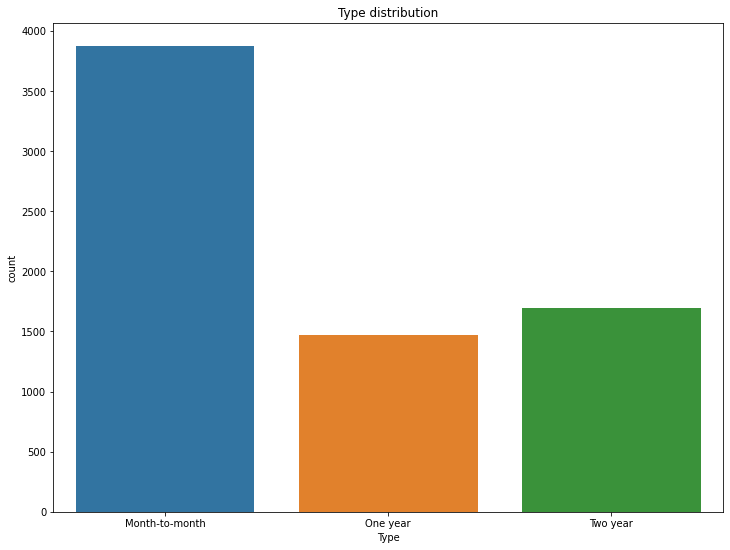

In [98]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = data_new ,x = 'Type').set(title = 'Type distribution')

Это фичура показывает, что люди охотнее выбирает месячную оплату, в то время как годова и двугодовая менее популярны. Стоит стимулировать их скидками

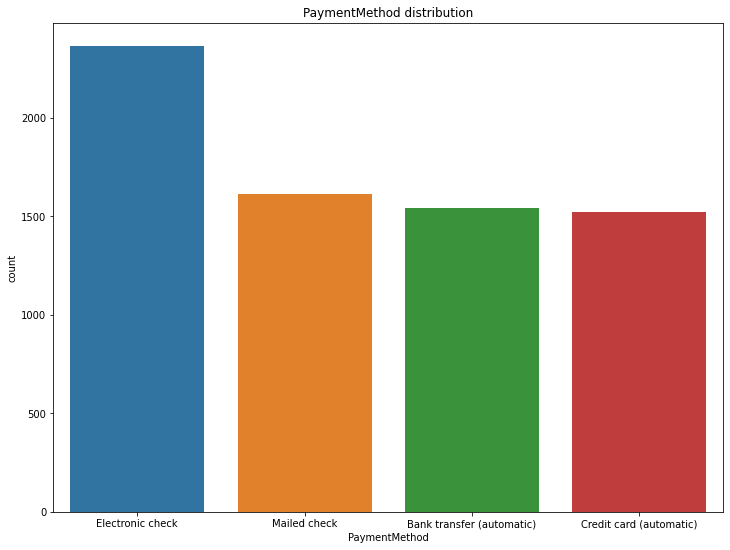

In [99]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = data_new ,x = 'PaymentMethod').set(title = 'PaymentMethod distribution')

Здесь почти нечего сказать, все методы оплаты по-своему популярны и почти равномерно распределены

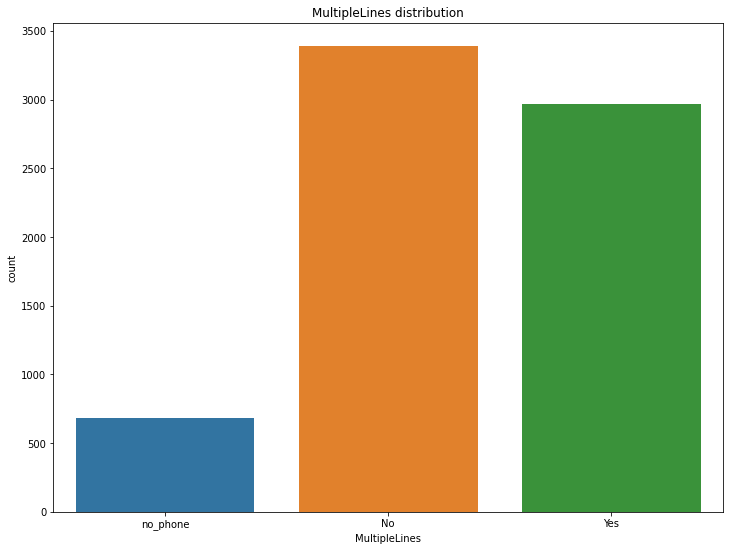

In [100]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = data_new ,x = 'MultipleLines').set(title = 'MultipleLines distribution')

Интересно то, что люди скорее всего приходят с телефонного подключения, а потом уже берут услуши, связанные с интернетом. Поэтому очень мало людей не пользуются услугами для телефона данного провайдера. В то же время, много людей пользуются несколькими линиями

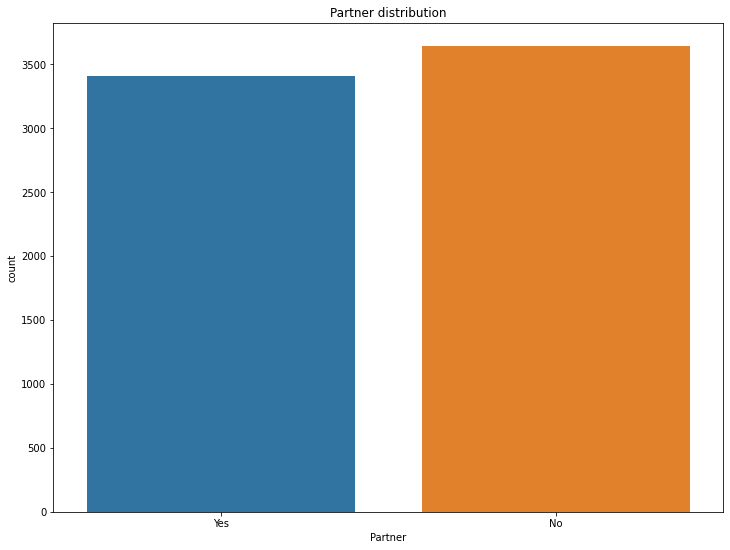

In [101]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.countplot(data = data_new ,x = 'Partner').set(title = 'Partner distribution')

В данной переменной почти одинаковое количество людей без партнеров и с партнерами

#### Continous features

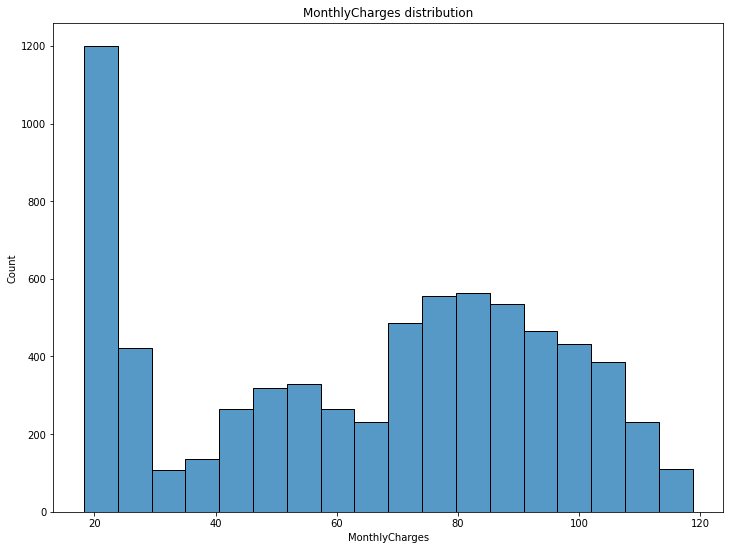

In [102]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.histplot(data = data_new ,x = 'MonthlyCharges').set(title = 'MonthlyCharges distribution')

По графику можно заметить, что нормально распределение начинается с 30 в месяц, до 30 мы можем заметить, что такое минимальная плата и сколько людей ей пользуются

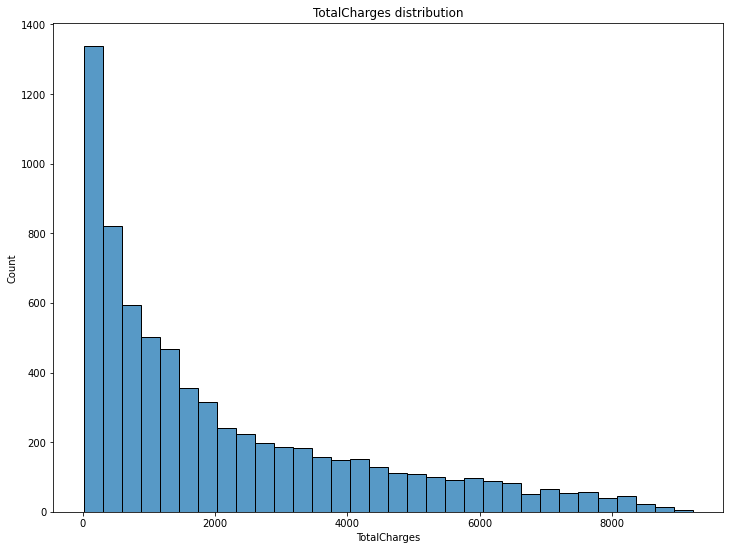

In [103]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.histplot(data = data_new ,x = 'TotalCharges').set(title = 'TotalCharges distribution')

График очень неинформотивен, потому что это граф накопления, то есть чем болше человек провел на сервисе, тем больше он потратил

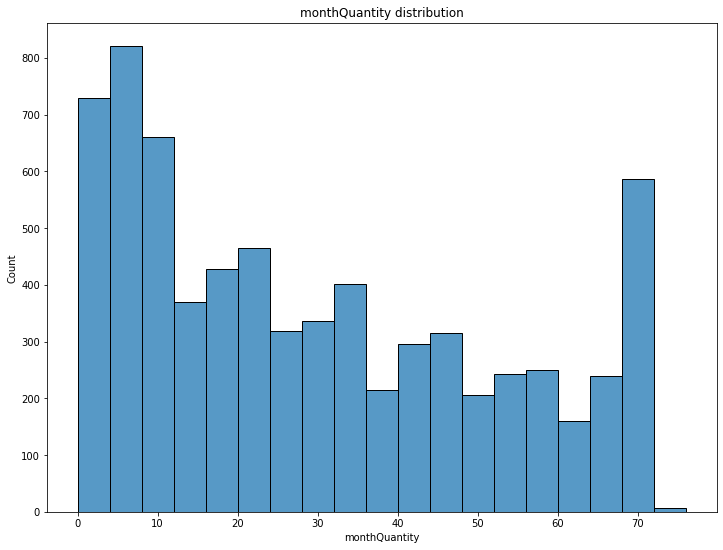

In [104]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.histplot(data = data_new ,x = 'monthQuantity').set(title = 'monthQuantity distribution')

По этому графику можно легко подметить, что сервисом пользуются как старожилы, так и новые клиенты. Интересно подмечая, можно увидеть, что много людей осталось с того спайка в 2014 году

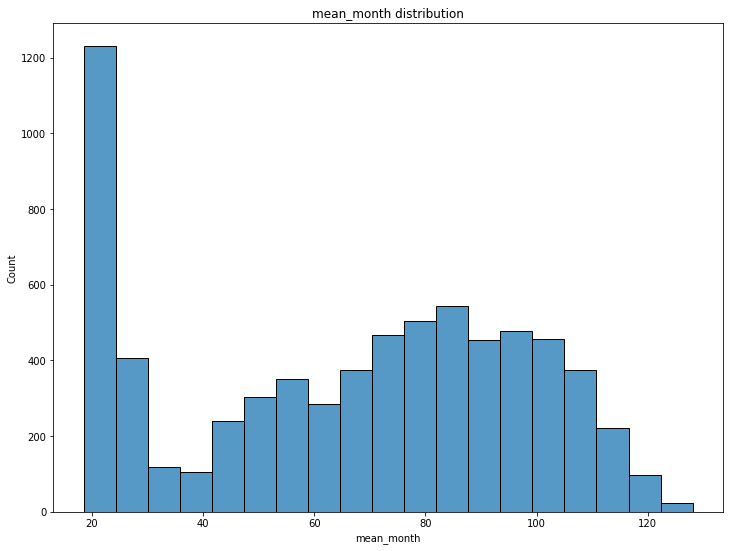

In [105]:
f, ax = plt.subplots(figsize=(12, 9))
a = sb.histplot(data = data_new ,x = 'mean_month').set(title = 'mean_month distribution')

Так как мы немного нормализовали график, поделя его на количество месяцев, теперь можно с уверенностью сказать, что много людей пользуются минимальной платой за месяц

### Исследование и комментирование дисбаланса класса 

можно заметить сильный дисбаланс классов, эту проблему легко решить с помощью функций моделей

### Деление на тренировочную и тестовую

In [106]:
data_new = data_new.drop(columns=['customerID','BeginDate','EndDate','EndDateNotTarget'],axis = 1)

In [107]:
data_new.columns

Index(['Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines', 'Partner', 'target', 'monthQuantity', 'mean_month'],
      dtype='object')

Удалил из даты все, что необходимо убрать

In [108]:
categorical_columns =['Type','PaymentMethod',
       'MultipleLines', 'Partner']

In [109]:
features_train ,features_test,target_train,target_test = train_test_split(data_new.drop(columns='target',
                                                                                    axis = 1),data_new['target'],
                                                                          test_size = 0.25, random_state=201123)

In [110]:
features_train.shape

(5282, 8)

### Pipelines

#### random_forest_pipeline 

In [111]:
transformer = ColumnTransformer([('scaler',
                            StandardScaler(),
                            ['MonthlyCharges','TotalCharges','monthQuantity','mean_month']),
                            ('encoder',OrdinalEncoder(),
                             categorical_columns)],
                           remainder = 'drop')


In [112]:
random_forest_pipeline = make_pipeline(transformer,         
                        RandomForestClassifier(random_state = 201123))

Так как энкодер не работает, придется делать вручную

In [113]:
random_forest_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'monthQuantity',
                                                   'mean_month']),
                                                 ('encoder', OrdinalEncoder(),
                                                  ['Type', 'PaymentMethod',
                                                   'MultipleLines',
                                                   'Partner'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=201123))])

Pipeline для дерева готов, осталось только передать его

#### catpipeline

In [114]:
cat_pipeline = make_pipeline(transformer,         
                        CatBoostClassifier(allow_writing_files=False,random_state = 201123))

In [115]:
cat_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'monthQuantity',
                                                   'mean_month']),
                                                 ('encoder', OrdinalEncoder(),
                                                  ['Type', 'PaymentMethod',
                                                   'MultipleLines',
                                                   'Partner'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7f162e70f820>)])

пайплайн готов,приступим к анализу

Закончив с обработкой данных, нужно перейти к обучению моделей

<!-- OrdinalEncoder -->

### Models

#### Catboost

In [116]:
cat_search = {'catboostclassifier__learning_rate' : [0.03, 0.06],
              'catboostclassifier__depth' : [1, 5, 7],
              'catboostclassifier__l2_leaf_reg': [2, 3, 4],
              'catboostclassifier__border_count' : [128],
              'catboostclassifier__n_estimators' : [200, 500, 1000],
              'catboostclassifier__boosting_type': ['Ordered', 'Plain']
             }

In [117]:
search_cat= RandomizedSearchCV(cat_pipeline,param_distributions = cat_search, scoring='roc_auc',n_jobs = -1, cv = 5,random_state = 201123)
search_cat.fit(features_train, target_train)
print(search_cat.best_estimator_, search_cat.best_params_, search_cat.best_score_)

0:	learn: 0.6418374	total: 53.1ms	remaining: 26.5s
1:	learn: 0.6034547	total: 57.5ms	remaining: 14.3s
2:	learn: 0.5688423	total: 62.2ms	remaining: 10.3s
3:	learn: 0.5399398	total: 66.7ms	remaining: 8.28s
4:	learn: 0.5141520	total: 71.3ms	remaining: 7.06s
5:	learn: 0.4894562	total: 75.8ms	remaining: 6.24s
6:	learn: 0.4735118	total: 80.6ms	remaining: 5.67s
7:	learn: 0.4583954	total: 84.9ms	remaining: 5.22s
8:	learn: 0.4431534	total: 89.1ms	remaining: 4.86s
9:	learn: 0.4295587	total: 93.6ms	remaining: 4.58s
10:	learn: 0.4181908	total: 98ms	remaining: 4.36s
11:	learn: 0.4080896	total: 103ms	remaining: 4.17s
12:	learn: 0.3997421	total: 106ms	remaining: 3.98s
13:	learn: 0.3943834	total: 109ms	remaining: 3.8s
14:	learn: 0.3887324	total: 114ms	remaining: 3.68s
15:	learn: 0.3808859	total: 118ms	remaining: 3.57s
16:	learn: 0.3774080	total: 122ms	remaining: 3.47s
17:	learn: 0.3726937	total: 127ms	remaining: 3.39s
18:	learn: 0.3703856	total: 130ms	remaining: 3.3s
19:	learn: 0.3677600	total: 134ms	

Получился хороший результат, модель показала 90% на тестовой выборке

RandomForestClassifier

In [118]:
params_forest = {'randomforestclassifier__criterion' : ['gini', 'entropy'],
                 'randomforestclassifier__max_features' : ['log2','sqrt'],
                 'randomforestclassifier__min_samples_split' : [i for i in range(2,49,10)],
                 'randomforestclassifier__min_samples_leaf' : [i for i in range(2,49,10)]
                 }

In [119]:
search = RandomizedSearchCV(random_forest_pipeline, param_distributions=params_forest, 
                            n_jobs = -1, cv =5 , random_state=201123)
search.fit(features_train,target_train)
print(search.best_estimator_, search.best_params_, search.best_score_)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'monthQuantity',
                                                   'mean_month']),
                                                 ('encoder', OrdinalEncoder(),
                                                  ['Type', 'PaymentMethod',
                                                   'MultipleLines',
                                                   'Partner'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features='log2', min_samples_leaf=2,
                                        min_samples_split=22,
                                        random_state=201123))]) {'randomforestclassifier__min_samples_split': 22, 'randomforestclassifier

Результат получился похуже, но все равно больше, чем того требует задание, время проверять лучшую модель на тестовой выборке

Вывод по лучшей модели:
- Результат на тестовой выборке получился выше минимального, что позволит перейти на следующий этап
- Лучшие параметры для данной задачи 
    - 'catboostclassifier__n_estimators': 1000,
    - 'catboostclassifier__learning_rate': 0.06, 
    - 'catboostclassifier__l2_leaf_reg': 4, 
    - 'catboostclassifier__depth': 5, 
    - 'catboostclassifier__border_count': 128,
    - 'catboostclassifier__boosting_type': 'Plain'
- Параметры немного напрягают своей тенденцией на переобучение, надо будет проверить точность
- Модель обучается быстро
- Результаты обучения можно увидеть под ячейкой

 ### Проверка лучшей модели на тестовой выборке

In [120]:
def plot_roc_curve(fpr, tpr, thresholds, auc_roc):
        
    plt.figure(figsize=[12,9])

    plt.plot([0, 1], [0, 1], linestyle='-', label='Threshold = 0.5')

    plt.plot(fpr, tpr, label=f'ROC-AUC = {auc_roc:.2f}')

    plt.xlim([0,1])
    plt.ylim([0,1])

    plt.xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')

    plt.legend(loc='lower right', fontsize='x-large')

    plt.title('ROC Curve for CatBoostClassifier', fontsize=16, fontweight='bold')
    plt.show()

In [121]:
pred = search_cat.predict(features_test)
pred_prob = search_cat.predict_proba(features_test)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, pred_prob)
auc_roc = roc_auc_score(target_test, pred_prob)
print('AUC-ROC модели Catboost на тестовой выборке:',auc_roc)

AUC-ROC модели Catboost на тестовой выборке: 0.9299407372288728


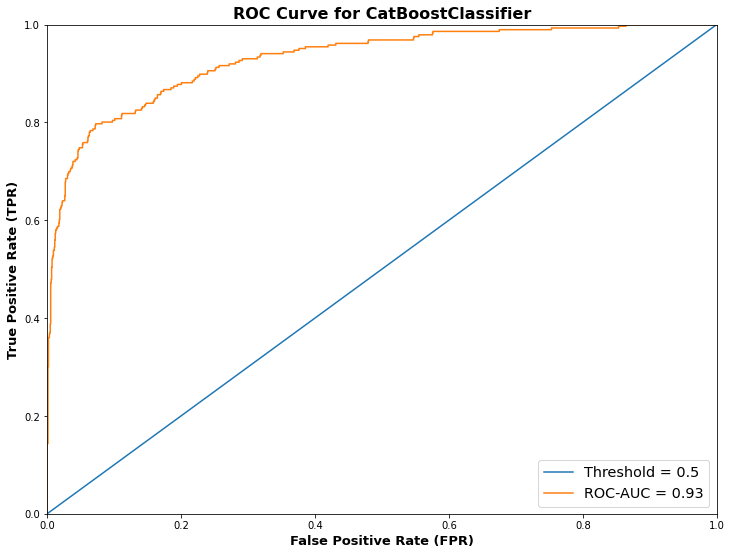

In [122]:
plot_roc_curve(fpr, tpr, thresholds, auc_roc)


Анализ roc_auc_curve
- модель показала roc_auc_score на пике в 93%
- Модель лучше чем pure guessing
- модель хорошо определяет, когда человек уйдет и останется, почему так, можно увидеть снизу

### Анализ и интерпритация важности признаков

Можно подметить:
- Высокие значения года сильно негативно влияют на аутпут модели
- Высокие значения общих трат невроятно негативно влияют на выхлоп модели, а значения больше нуля в то же время дают в абсолютных значениях меньше, поэтому стоит подумать, стоит ли учитывать траты в моделях в юудущем
- Ежемесячные траты напротив, сильно помогают модели сделать выбор
- месяц тоже изменить, заменив на определенные месяцы, ведь именно определенные дают больше в метрике
- Дамми почти не влияю на этом графике, но это всего лишь особенность этого графика, если посмотреть на прошлый, то можно заметить, что вместе они хорошо повышают метрику

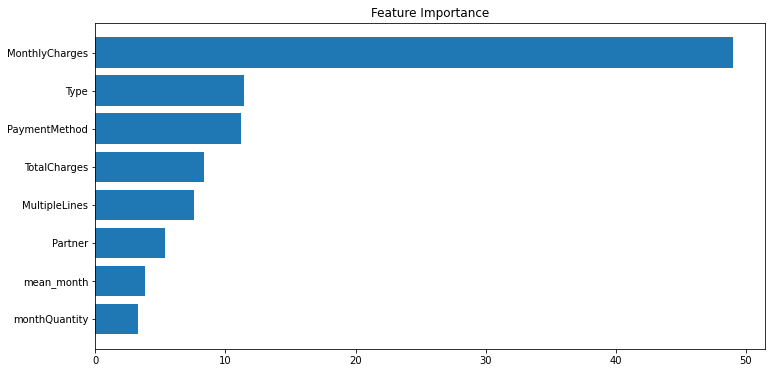

In [123]:
features_importance_built_in(search_cat)

Features importance
- ежемесячные траты объясняют 50% данных, придется воспользовать shap,чтобы понять как именно это объяснить
- тип платы и тип оплаты по 10%, что может обозначать зависимость между желанием оставаться 

Shap

Title: shap values for importance


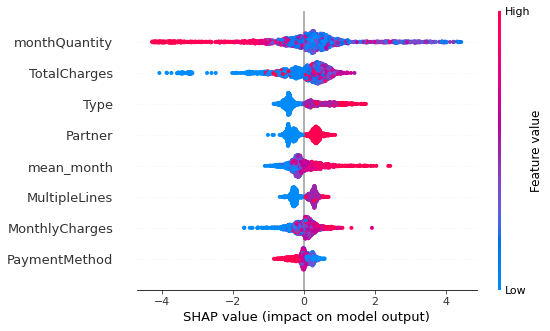

In [124]:
shap_explanation()

Результаты анализа с помощью shap
- Почти все признаки очень сильно влияют на предсказание модели
- Важность признаков распределена сверху вниз: с самых важных до менее важных
- Можно отметить, что бизнесу стоит обратить внимание на количество месяцев(сколько клиент времени пользуется услугами)
    - Чем больше клиент пользуется услугами, тем больше вероятность, что он останется
    - Чем меньше клинет пользуется услугами, тем меньше
- Тип оплаты тоже влияет, что он интересно, ведь если оплачено за следующий год, то он скорее всего останется
- Среднее по месяцу тоже хорошо показывает себя, чем больше человек платит, тем меньше он хочет оставаться в компании

### Анализ и интерпритация матрицы ошибок 

In [125]:
predictions_cat = search_cat.best_estimator_.fit(features_train,target_train).predict(features_test)


0:	learn: 0.6472901	total: 1.3ms	remaining: 1.3s
1:	learn: 0.6081221	total: 2.77ms	remaining: 1.38s
2:	learn: 0.5687907	total: 4.19ms	remaining: 1.39s
3:	learn: 0.5476847	total: 5.23ms	remaining: 1.3s
4:	learn: 0.5169548	total: 6.68ms	remaining: 1.33s
5:	learn: 0.4929536	total: 8.1ms	remaining: 1.34s
6:	learn: 0.4749280	total: 9.56ms	remaining: 1.36s
7:	learn: 0.4544628	total: 11ms	remaining: 1.36s
8:	learn: 0.4387515	total: 12.4ms	remaining: 1.36s
9:	learn: 0.4268694	total: 13.7ms	remaining: 1.36s
10:	learn: 0.4168111	total: 15.1ms	remaining: 1.36s
11:	learn: 0.4090126	total: 16.6ms	remaining: 1.37s
12:	learn: 0.4000237	total: 17.9ms	remaining: 1.36s
13:	learn: 0.3913258	total: 19.2ms	remaining: 1.35s
14:	learn: 0.3842532	total: 20.7ms	remaining: 1.36s
15:	learn: 0.3786193	total: 22ms	remaining: 1.35s
16:	learn: 0.3726075	total: 23.4ms	remaining: 1.35s
17:	learn: 0.3679727	total: 24.9ms	remaining: 1.36s
18:	learn: 0.3642006	total: 26.2ms	remaining: 1.35s
19:	learn: 0.3604766	total: 27

In [126]:
accuracy_score(predictions_cat,np.array(target_test))

0.919931856899489

- Accuracy в 92% показывает, что наша модель может определить, что человек уйдет или нет в 92% случаев

In [127]:
tn, fp, fn, tp = confusion_matrix(predictions_cat,target_test).ravel()

In [128]:
tn, fp, fn, tp

(1453, 119, 22, 167)

Модель справилась хорошо, потому что: 
- fp= 119, модель всего 119 раз сказала, что человек уйдет, хотя он не ушел
- fn= 22, модель всего 22 раза ошибочно определила, что человек не уйдет, когда он ушел
- tn = 1453, наша модель правильно определила, что человек не уйдет в 96% случаев (правильно определила)
- tp = 167, наша модель определила, что человек уйдет в  90%(правильно определила)

В итоге, модель хорошо показала себя в двуз разных местах:
- Высокой метрике
- Хорошей accuracy 

### Итоговый вывод

1. На первом этапе была сформирована цель исследования, представлено описание услуг заказчика, а также описание данных, состоящих из четырех сsv файлов
2. На втором этап:
    - Были рассмотрены каждые файлы по отдельности
    - Выявлен целевой признак
    - Объединены файлы в один, по признаку LEFTJOIN
    - Обработаны пропуски 
    - Добавлены новые признаки
    - Рассмотрена диаграми корелляции
    - Рассмотрены признаки
3. После исследования датасета и его обработки, были выявлены признаки, которые помогут нам в выполнении поставленной задачи: достижения высокого auc_score и точности
4. В достижении данной задачи я решил использовать модели, которые очень хорошо показывали себя в прошлом:
    - RandomForestClassifier
    - CatboostClassifier
5. После установки pipeline - важного элемента в данной задаче, которые включает в себя:
    - OrdinalEncoder - трансформер данных, который закодировал нецифровые переменные
    - StandardScaler - трансформер данных, приводящий переменные к нормальном распрделению
6. Посел нахождения лучших параметром с помощью RandomizedSeacrhCV, я нашел лучшую модель -catboostClassifier с лучшими параметрами
   - 'catboostclassifier__n_estimators': 1000,
   - 'catboostclassifier__learning_rate': 0.06,
   - 'catboostclassifier__l2_leaf_reg': 4,
   - 'catboostclassifier__depth': 5,
   - 'catboostclassifier__border_count': 128,
   - 'catboostclassifier__boosting_type': 'Plain'
7. После проверил лучшую модель(модель с самым высоким roc_auc_score) на тестовой выборке и получил высокий результат в 93%
8. Затем посмотрел важность признаков и смог сформировать рекомендации для бизнеса
    - Стоит поощерять людей, которые только начали пользоваться услугами и делать им скидки, так мы сможем покрыть два самых важных параметра
    - Смотреть, чтобы средние цены несильно менялись, потому что это может привести к оттоку клиентов
    - Можно собрать больше данных и попробовать исследовать другие аспекты, связанные с клиентами, для увелечения точности